# Introduction

This notebook is a quick starter guide on Uproot, Awkward Array, Vector, Hist, and mplhep, which are all packages that are part of the Scikit-HEP project, a collection of Python tools for HEP data analysis. We'll briefly go through parts of each and see how they work together.

Most of this notebook is adapted from my [Uproot tutorial](https://hsf-training.github.io/hsf-training-uproot-webpage/index.html) aimed at beginners in data analysis in Python. Here, I'm assuming that the reader is already familiar with at least Python, NumPy, and Matplotlib, so I've compressed the tutorial and added a bit of more advanced material, but it still just scratches the surface of these packages. See the links at the end for more extensive resources.

# Setup

## Installation

These packages can be installed in the usual way if they haven't been already:

`pip install uproot awkward vector hist mplhep`

They are also available via `conda install` on the `conda-forge` channel.

## Usage

We'll need NumPy and Matplotlib:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150 # make figures bigger and more readable

and all the packages mentioned above (Awkward Array is usually imported as `ak` as an analogy to `numpy as np`):

In [2]:
import uproot
import awkward as ak
import vector
import hist
import mplhep as hep

# Motivating example

In order to learn how to use these packages, we’ll try to do a very short and simple analysis to look for resonances in dimuon events. The example ROOT file is from CMS open data from proton-proton collisions in 2012.

# Inspecting data

Our first goal is just to get to the data within Uproot, so we need to open the file and navigate to the muon information.

## Files

### Opening a file

Open the ROOT file and assign it to a variable:

In [3]:
file = uproot.open('open-data-example.root')

If you inspect file, you can see that it’s a `ReadOnlyDirectory` object:

In [4]:
file

<ReadOnlyDirectory '/' at 0x7f1d198ddf60>

### File contents

Just like any other kind of directory, you can list the contents (of the file). The name of each item in the file is called a key.

In [5]:
file.keys()

['Events;1']

We can see that there is one key: “Events”. This doesn’t tell us what kind of object it refers to, though. ROOT files can contain many different types of objects, including subdirectories. The following function provides a way to inspect the types of each item:

In [6]:
file.classnames()

{'Events;1': 'TTree'}

The output contains pairs of the form `name: type`. Therefore the key `Events` refers to a `TTree` object. This is where all the data in this file is stored. The `;1` refers to the cycle number.

### Accessing contents

Now we want to actually access the object inside the file. You can do this just as you would to get an item in an array:

In [7]:
file['Events']

<TTree 'Events' (6 branches) at 0x7f1d1bd7bb80>

This expression refers to the actual TTree object, which we will look at next.

## Trees

Trees in ROOT are basically just tables of information. Trees are composed of branches, which are the columns of the table. The rows usually represent events (individual bunch crossings).

First we assign the tree to a variable:

In [8]:
tree = file['Events']

In order to find out what information is in the tree, we need to know what the branches (columns) are. The term `key` is used (again) here to refer to the names of the branches.

In [9]:
tree.keys()

['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge']

The above output is a list of the branch names. So we can see that for each event, we will have the number of muons in the event (nMuon) and the pT, eta, phi, mass, and charge of each muon. We can also see these keys with the types included using `.show()`:

In [10]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge          | int32_t[]                | AsJagged(AsDtype('>i4'))


## Aside: uproot-browser

An alternative option for inspecting a ROOT file is `uproot-browser`, which is a Python package that uses Uproot to provide a terminal interface similar to the ROOT `TBrowser` graphical interface. For example, with `uproot-browser browse open-data-example.root`:

![](uproot-browser_1.png)
![](uproot-browser_2.png)

# Extracting data

## Trees

But how do we get the actual data from the table? There are several ways with Uproot, but the simplest is with the arrays() function:

In [11]:
tree.arrays()

<Array [{nMuon: 2, Muon_pt: [10.8, ... -1, 1]}] type='100000 * {"nMuon": uint32,...'>

You can see some numbers in there, which indeed are from the data in the tree.

## Branches

Now we assign this object (which contains both the names and contents of the branches) to another variable (branches):

In [12]:
branches = tree.arrays()

Next let’s just look at each branch individually. You can access a single branch from branches in a similar way to getting an item from a ROOT file object (array-like notation):

In [13]:
branches['nMuon']

<Array [2, 2, 1, 4, 4, 3, ... 0, 3, 2, 3, 2, 3] type='100000 * uint32'>

You can also access branches with attribute/property notation:

In [14]:
branches.nMuon

<Array [2, 2, 1, 4, 4, 3, ... 0, 3, 2, 3, 2, 3] type='100000 * uint32'>

You can see the partial list of numbers in the output that represents the number of muons in each event. It’s abbreviated with an ellipsis (...) so that it doesn’t take up the whole page.

These Array objects are a special type provided by the Awkward Array package. The type=100000 * uint32 means that there are 100,000 entries and that each entry is a 32-bit unsigned integer. Each entry corresponds to one event.

Let’s look at another branch:

In [15]:
branches['Muon_pt']

<Array [[10.8, 15.7], ... 11.4, 3.08, 4.97]] type='100000 * var * float32'>

This is a _jagged_ array because the number of entries is different for different events (because each event can have a different number of muons). Note that there are square brackets [] surrounding the list of entries for each event. The type='100000 * var * float32' means that there are 100,000 rows, each containing a variable number of 32-bit floating point numbers. This is basically an array of arrays (or a 2D array).

Jagged arrays are the primary reason for using Awkward Array over pure NumPy. Awkward Array allows us to manipulate jagged arrays in ways analagous to how NumPy can manipulate rectangular (non-jagged) arrays.

## Events

If we want to focus on a particular event, we can index it just like a normal array:

In [16]:
branches['Muon_pt'][0]

<Array [10.8, 15.7] type='2 * float32'>

From the above output, the first event has two muons, and the two numbers in the list are the muons’ $p_\mathrm{T}$. It’s not specified anywhere in the file, but the units are GeV. Let’s look at the third event:

In [17]:
branches['Muon_pt'][2]

<Array [3.28] type='1 * float32'>

It only has one muon.

What if we want to get all of the information about a single event? So far we’ve accessed data in branches by providing a branch name, but we can also just use an event index:

In [18]:
branches[0]

<Record ... 0.106], Muon_charge: [-1, -1]} type='{"nMuon": uint32, "Muon_pt": va...'>

If you only want to see a description of the structure of the array and types within it (not the data itself), you can use `.type`:

In [19]:
branches.type

100000 * {"nMuon": uint32, "Muon_pt": var * float32, "Muon_eta": var * float32, "Muon_phi": var * float32, "Muon_mass": var * float32, "Muon_charge": var * int32}

This is a `Record` object, which is another special type provided by Awkward Array. It functions basically the same way as a standard Python dictionary (dict). Unfortunately, most of the interesting information is still hidden in the above output to save space. A little trick we can use to force printing all the data is adding `.tolist()`:

In [20]:
branches[0].tolist()

{'nMuon': 2,
 'Muon_pt': [10.763696670532227, 15.736522674560547],
 'Muon_eta': [1.0668272972106934, -0.563786506652832],
 'Muon_phi': [-0.03427272289991379, 2.5426154136657715],
 'Muon_mass': [0.10565836727619171, 0.10565836727619171],
 'Muon_charge': [-1, -1]}

There we go. Now we can see the whole picture for an individual event.

`.tolist()` is a NumPy function that has been extended to Awkward Array objects. As the name suggests, it converts NumPy arrays to Python lists. In the case of trees, which have named branches, it actually converts to a dictionary of lists. It can be very useful when you want to understand exactly what’s in an Array or Record. Be careful when using it, though–trying to print out an entire branch or tree could cause Python to crash if it’s large enough. Therefore it’s best to only use `tolist()` on one or a few events at a time to be safe.

# Histogramming

Histograms are a critical component of analysis in HEP. Here, we create histograms via Hist, which uses the powerful `boost-histogram` library. Hist provides the interface for defining histograms and filling them. Generating the actual graphical plots of histograms is handled by mplhep and matplotlib. mplhep is a package that extends matplotlib with several convenient features that are specifically important for HEP data analysis.

For example, since we're looking for dimuon events, let's make a histogram of the number of muons in each event:

/home/user/miniconda3/envs/agc-foundation-demo/lib/python3.10/site-packages/mplhep/utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


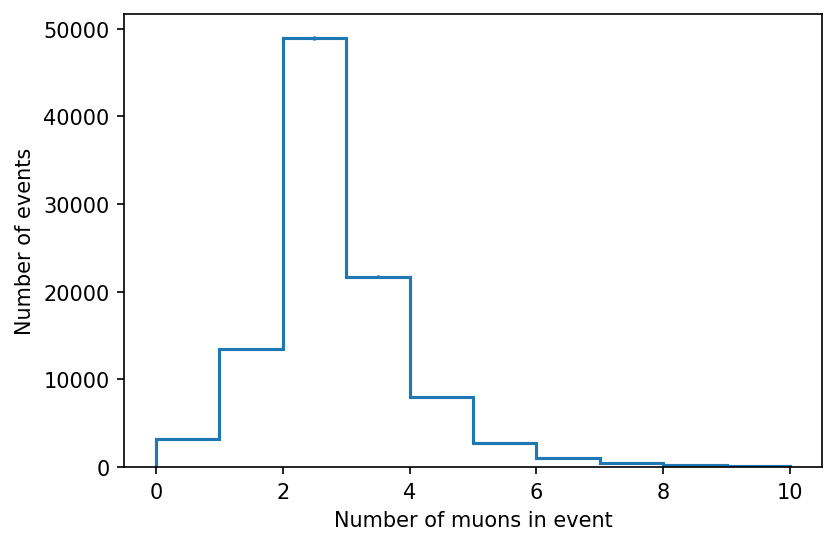

In [21]:
h = hist.Hist(hist.axis.Regular(10, 0, 10, label='Number of muons in event'))
h.fill((branches['nMuon']))
h.plot()
plt.ylabel('Number of events')
plt.show()

So almost half of the events have exactly two muons, but there are plenty with zero, one, or more than two.

# Manipulating data

Uproot and Awkward Array are designed for columnar analysis, which means performing operations on entire columns (branches) at a time, rather than operating on every event individually like in traditional event loop frameworks. This shift can take some getting used to at first, but it is generally much more computationally efficient.

## Counting

The simplest task we need for analysis is counting (i.e., cutflow). To count the total number of events, we can use the Python built-in function `len()` on any of the following:

```python
len(branches)
len(branches['nMuon'])
len(branches['Muon_pt']) # or any of the other branches...
```

which will output `100000`. So there are 100,000 events.

Note that `len` will only tell you the length of the outermost dimension. The `Muon_pt` branch has more than 100,000 numbers in it. We can see this by flattening the array. `np.ravel` is a simple way to completely flatten an array:

In [22]:
np.ravel(branches['Muon_pt'])

<Array [10.8, 15.7, 10.5, ... 11.4, 3.08, 4.97] type='235286 * float32'>

Note that I've used a NumPy function here on an `ak.Array`. Most of the standard NumPy functions work fine on Awkward `Array`s, although there are also equivalent Awkward functions like `ak.ravel`. Generally speaking, the default behavior between these NumPy and Awkward functions is the same, but the `ak` versions have optional parameters for functionality that is specific to jagged arrays. 

Awkward Array also has functions that wouldn't make sense in NumPy. For counting the number of entries in each event for a branch, there's `ak.num`:

In [23]:
ak.num(branches['Muon_pt'])

<Array [2, 2, 1, 4, 4, 3, ... 0, 3, 2, 3, 2, 3] type='100000 * int64'>

which in this case is equal to already existing `branches['nMuon']`. In NumPy, there's no need for this function, since it would be the same number over and over, and you could just get it from `np.ndarray.shape`.

## Selections

### Selections from 1D arrays

To do more interesting counting or plotting, we want to be able to select only events or muons that pass some criteria. Just as you can compare two numbers, like `1 < 2` and get a `True` or `False` value, you can put arrays in comparisons as well. Let’s look at this case:

In [24]:
branches['nMuon'] == 1

<Array [False, False, True, ... False, False] type='100000 * bool'>

This is checking for equality between an array and the number 1. Of course these are different types (array vs. scalar), so the Python objects are certainly not identical, but you can see the return value is not just False. What happens is that each element in the array is compared to the scalar value, and the return value is a new array (of the same shape) filled with all these comparison results. So we can interpret the output as the result of testing whether each event has exactly one muon or not. The first two events do not, the third does, and so on.

This array of Boolean values is called a mask because we can use it to pick out only the elements in the array that satisfy some criteria (like having exactly one muon). This is very useful, and we will save it to a variable to save typing later:

In [25]:
single_muon_mask = branches['nMuon'] == 1

### Counting with selections

Now let’s say we want to know how many of these single-muon events there are. Note that `len()` won’t work because the length of the array is still 100,000. That is, there’s a value for every event (even if that value is `False`). We need the number of `True`s in the array. There are multiple ways to do this, but my favorite is:

In [26]:
np.sum(single_muon_mask)

13447

`sum()` adds all the array values together. `True` is interpreted as `1` and `False` is interpreted as `0`, thus `sum()` is just the number of True entries. So there are 13,447 events with exactly one muon.

### Applying a mask to an array

If we want to apply some selection to an array (i.e., cut out events or muons that don’t pass), we just act like the selection mask is an index. For example, if we want the pT of only those muons in events with exactly one muon (so they’re the only muon in that event):

In [27]:
branches['Muon_pt'][single_muon_mask]

<Array [[3.28], [3.84], ... [13.3], [9.48]] type='13447 * var * float32'>

We can check that we really are only looking at the events that pass the selection by looking the number of rows:

In [28]:
len(branches['Muon_pt'][single_muon_mask])

13447

Yep, this matches the counting from single_muon_mask.sum() above.

### Plotting with selections

We can also use masks to plot quantities after some selection. For example, let’s plot the muon $p_\mathrm{T}$ for only the single-muon events. Note that, just like for multidimensional NumPy arrays, `Array`s must be flattened before histogramming.

/home/user/miniconda3/envs/agc-foundation-demo/lib/python3.10/site-packages/mplhep/utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


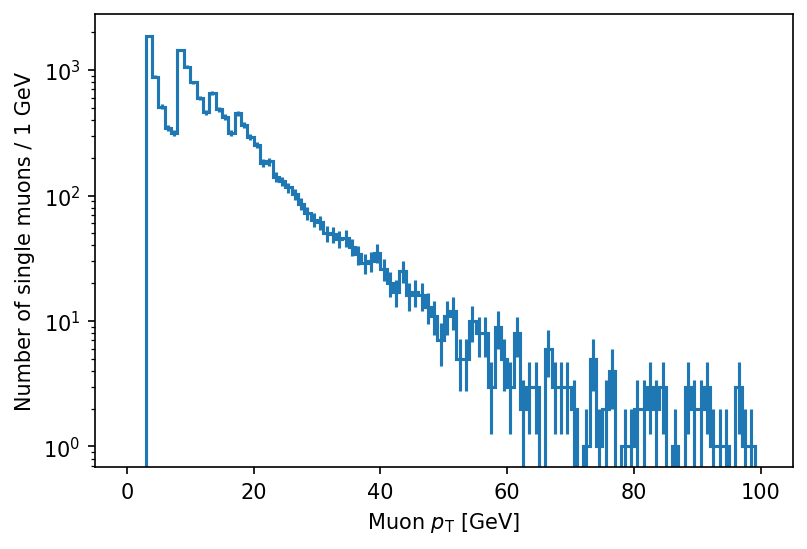

In [29]:
h = hist.Hist(hist.axis.Regular(100, 0, 100, label='Muon $p_{\mathrm{T}}$ [GeV]'))
h.fill(np.ravel(branches['Muon_pt'][single_muon_mask]))
h.plot()
plt.yscale('log')
plt.ylabel('Number of single muons / 1 GeV')
plt.show()

### Selections from a jagged array

Let’s look at a comparison for a jagged array, using the absolute value of muon eta:

In [30]:
eta_mask = abs(branches['Muon_eta']) < 2
eta_mask

<Array [[True, True], ... True, True, True]] type='100000 * var * bool'>

Again, the mask array has the same dimensions as the original array. There’s one Boolean value for each muon, corresponding to whether its eta is less than 2 in absolute value.

We can do counting and plotting just as before:

In [31]:
np.sum(eta_mask)

204564

This is the number of muons that pass the eta cut.

### Plotting

Let’s plot both the original eta distribution and the one after the cut to verify its effect:

In [32]:
eta_hist = hist.Hist(hist.axis.Regular(50, -2.5, 2.5, label=r'Muon $\eta$'))

/home/user/miniconda3/envs/agc-foundation-demo/lib/python3.10/site-packages/mplhep/utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


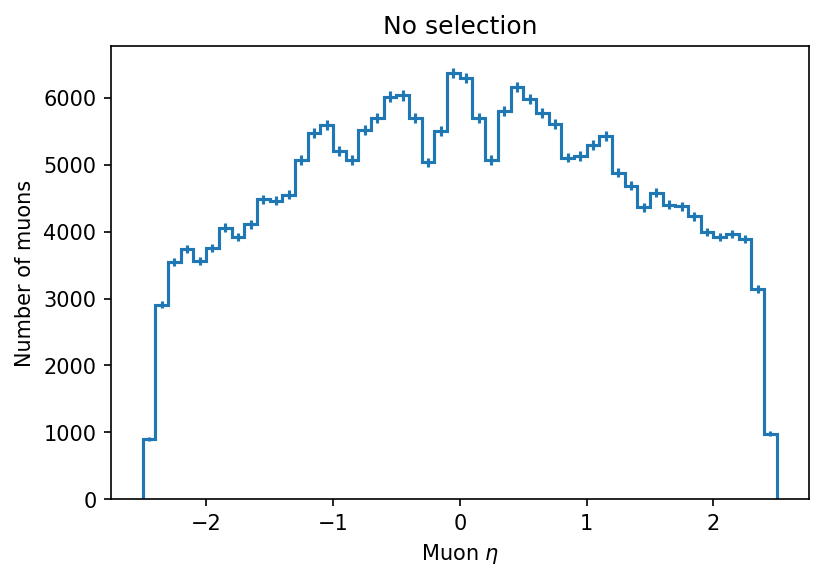

In [33]:
eta_hist.fill(np.ravel(branches['Muon_eta']))
eta_hist.plot()
plt.title('No selection')
plt.ylabel('Number of muons')
plt.show()

In [34]:
eta_hist.reset()

Hist(Regular(50, -2.5, 2.5, label='Muon $\\eta$'), storage=Double())

/home/user/miniconda3/envs/agc-foundation-demo/lib/python3.10/site-packages/mplhep/utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


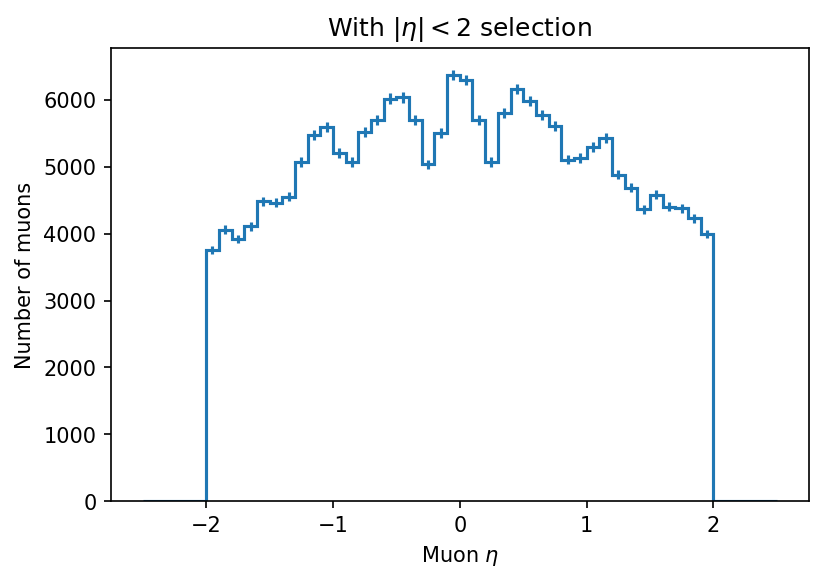

In [35]:
eta_hist.fill(np.ravel(branches['Muon_eta'][eta_mask]))
eta_hist.plot()
plt.title('With $|\eta| < 2$ selection')
plt.ylabel('Number of muons')
plt.show()

You can see the second plot just has both ends past 2 cut off, demonstrating that we’ve cut those muons out.

### Operations on selections

We can invert selections with `~` (the NOT operator):

In [36]:
~single_muon_mask

<Array [True, True, False, ... True, True] type='100000 * bool'>

This new mask is False only for events with exactly one muon and True otherwise.

We can get the intersection of selections with `&` (the AND operator):

In [37]:
single_muon_mask & eta_mask

<Array [[False, False], ... False, False]] type='100000 * var * bool'>

This mask is True only for muons with no other muons in their event and `abs(eta) < 2`.

Or we can get the union of selections with `|` (the OR operator):

In [38]:
single_muon_mask | eta_mask

<Array [[True, True], ... True, True, True]] type='100000 * var * bool'>

This mask is True for muons which are the only muon in their event or which have `abs(eta) < 2`.

### Comparing histograms

Now we can use these operations to compare distributions for different selections. Let’s look at the $p_\mathrm{T}$ of single-event muons split into two groups by whether or not `abs(eta) < 2`. All we have to do is provide a list of arrays as the first argument to hist rather than just one array. Note the square brackets around the two arrays:

/home/user/miniconda3/envs/agc-foundation-demo/lib/python3.10/site-packages/mplhep/utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


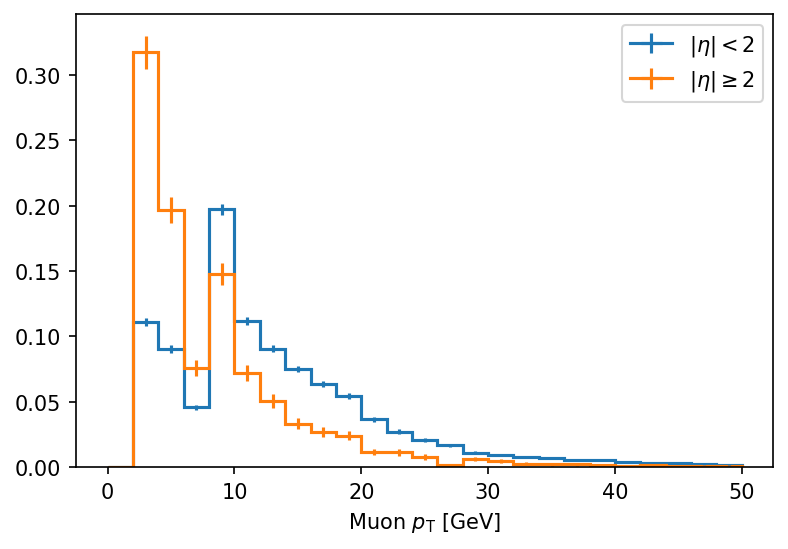

In [39]:
pt_hist = hist.Hist(hist.axis.Regular(25, 0, 50, label='Muon $p_{\mathrm{T}}$ [GeV]'),
                    hist.axis.StrCategory([], growth=True, name='category'))

pt_hist.fill(np.ravel(branches['Muon_pt'][single_muon_mask & eta_mask]), category='$|\eta| < 2$')
pt_hist.fill(np.ravel(branches['Muon_pt'][single_muon_mask & ~eta_mask]), category='$|\eta| \geq 2$')
pt_hist.plot(density=True)
plt.legend()
plt.show()

Now we can clearly see there’s a significantly higher fraction of muons with `abs(eta) >= 2` at lower pT compared to muons with `abs(eta) < 2`. This makes geometric sense, since muons at higher `abs(eta)` are traveling in a direction less perpendicular to the beam.

# Analyzing data

Okay, we’re finally ready to look for resonances in dimuon events.

We need a mask that selects events with exactly two muons:

In [40]:
two_muons_mask = branches['nMuon'] == 2

## Aside: Interpretation of arrays

Awkward Array allows for defining _behaviors_ for certain kinds of arrays. This can provide domain-specific functionality for interpreting specialized arrays. For example, we often need to perform four-vector manipulations in HEP analyses, so it would be convenient to have functions available for calculationg common quantities like $\Delta R$ and to override Python addition to perform four-vector sums. This kind of specialization can be configured with `ak.behaviors`. For the example case of four-vectors, this is already provided by a package called Vector.

## Vectors

We need to construct the four-momenta of each muon. Vector is a package that provides an interface to operate on 2D, 3D, and 4D vectors. We can get the four-momenta of all muons in the tree by using `vector.zip` and passing it the $p_\mathrm{T}$, eta, phi, and mass arrays:

In [41]:
muon_p4 = vector.zip({'pt': branches['Muon_pt'], 'eta': branches['Muon_eta'], 'phi': branches['Muon_phi'], 'mass': branches['Muon_mass']})

We’ll go ahead and filter out events that don’t contain exactly two muons:

In [42]:
two_muons_p4 = muon_p4[two_muons_mask]

Then let’s take a look at it:

In [43]:
two_muons_p4

<MomentumArray4D [[{rho: 10.8, ... tau: 0.106}]] type='48976 * var * Momentum4D[...'>

This is an array of 4D momenta. We can get the components back out with these properties:

```python
two_muons_p4.pt
two_muons_p4.eta
two_muons_p4.phi
two_muons_p4.E
two_muons_p4.mass
```

What we want is the invariant mass of the two muons in each of these events. To do that, we need the sum of their four-vectors. First, we pick out the first muon in each event with 2D slice:

In [44]:
first_muon_p4 = two_muons_p4[:, 0]

In the notation `[:, 0]`, : means “include every row in the first dimension” (i.e., all events in the array). The comma separates the selection along the first dimension from the selection along the second dimension. The second dimension is the muons in each event, so we want the first, or the one at the 0 index. Then we do the same to get the second muon in each event, just changing the 0 index to 1:

In [45]:
second_muon_p4 = two_muons_p4[:, 1]

### $\Delta R$

Another useful feature of these four-vector arrays is being able to compute $\Delta R$ ($= \sqrt{{\Delta \eta}^2 + {\Delta \phi}^2}$):

In [46]:
first_muon_p4.deltaR(second_muon_p4)

<Array [3.05, 2.92, 3.16, ... 4.47, 3.06, 2.88] type='48976 * float32'>

/home/user/miniconda3/envs/agc-foundation-demo/lib/python3.10/site-packages/mplhep/utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


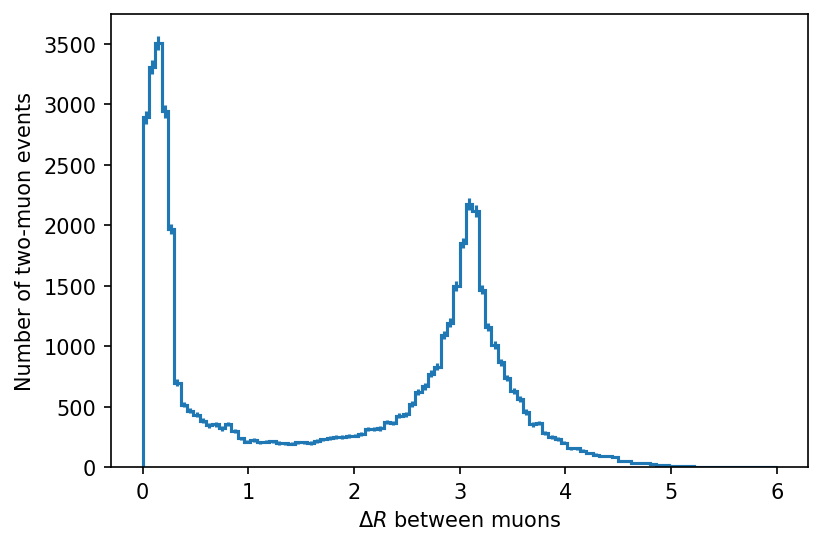

In [47]:
deltaR_hist = hist.Hist(hist.axis.Regular(100, 0, 6, label='$\Delta R$ between muons'))
deltaR_hist.fill(first_muon_p4.deltaR(second_muon_p4))
deltaR_hist.plot()
plt.ylabel('Number of two-muon events')
plt.show()

In principle, we could use this to clean up our invariant mass distribution, but we’ll skip that for simplicity.

### Dimuon mass

Adding the four-vectors of the first muon and the second muon for all events is really as easy as:

In [48]:
sum_p4 = first_muon_p4 + second_muon_p4
sum_p4

<MomentumArray4D [{rho: 8.79, phi: 1.83, ... tau: 16.5}] type='48976 * Momentum4...'>

This is a 1D array of the four-vector sum for each event.

## Physics

Finally, we want to pick out the opposite-charge dimuon events and look at the distribution of invariant mass. This was our original physics goal in this toy analysis.

We create the necessary event mask:

In [49]:
two_muons_charges = branches['Muon_charge'][two_muons_mask]
opposite_sign_muons_mask = two_muons_charges[:, 0] != two_muons_charges[:, 1]

We apply this selection to the four-vector sums to get the dimuon four-vectors:

In [50]:
dimuon_p4 = sum_p4[opposite_sign_muons_mask]

And plot:

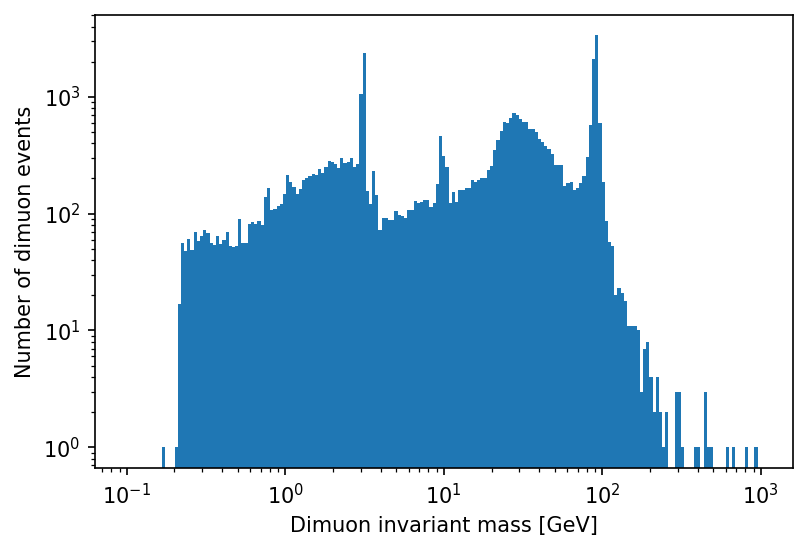

In [51]:
dimuon_mass_hist = hist.Hist(hist.axis.Variable(np.logspace(-1, 3, 200), label='Dimuon invariant mass [GeV]'))
dimuon_mass_hist.fill(dimuon_p4.mass)
hep.histplot(dimuon_mass_hist, histtype='fill')
plt.xscale('log')
plt.ylabel('Number of dimuon events')
plt.yscale('log')

How many dimuon events were selected in total?

In [52]:
len(dimuon_p4)

37183

The plot should look like this, where the resonances have been labeled below:

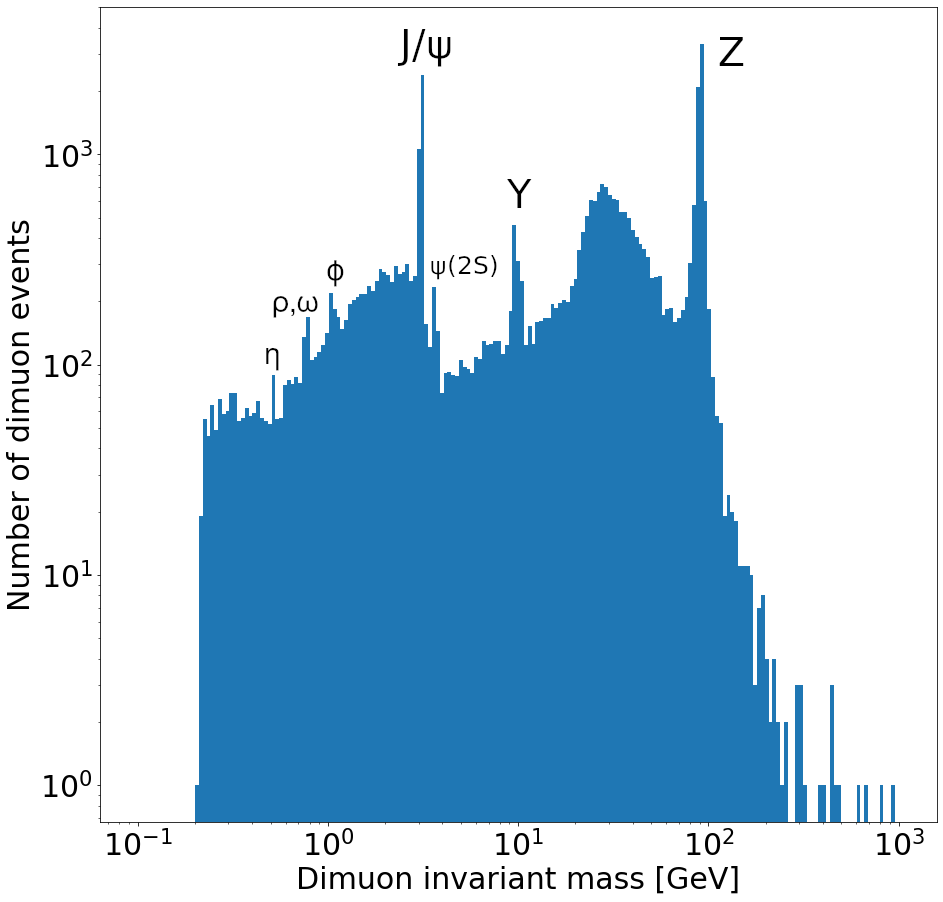

One of the main features of mplhep is that it provides functions to style histograms to match experiment-specific conventions and labels:

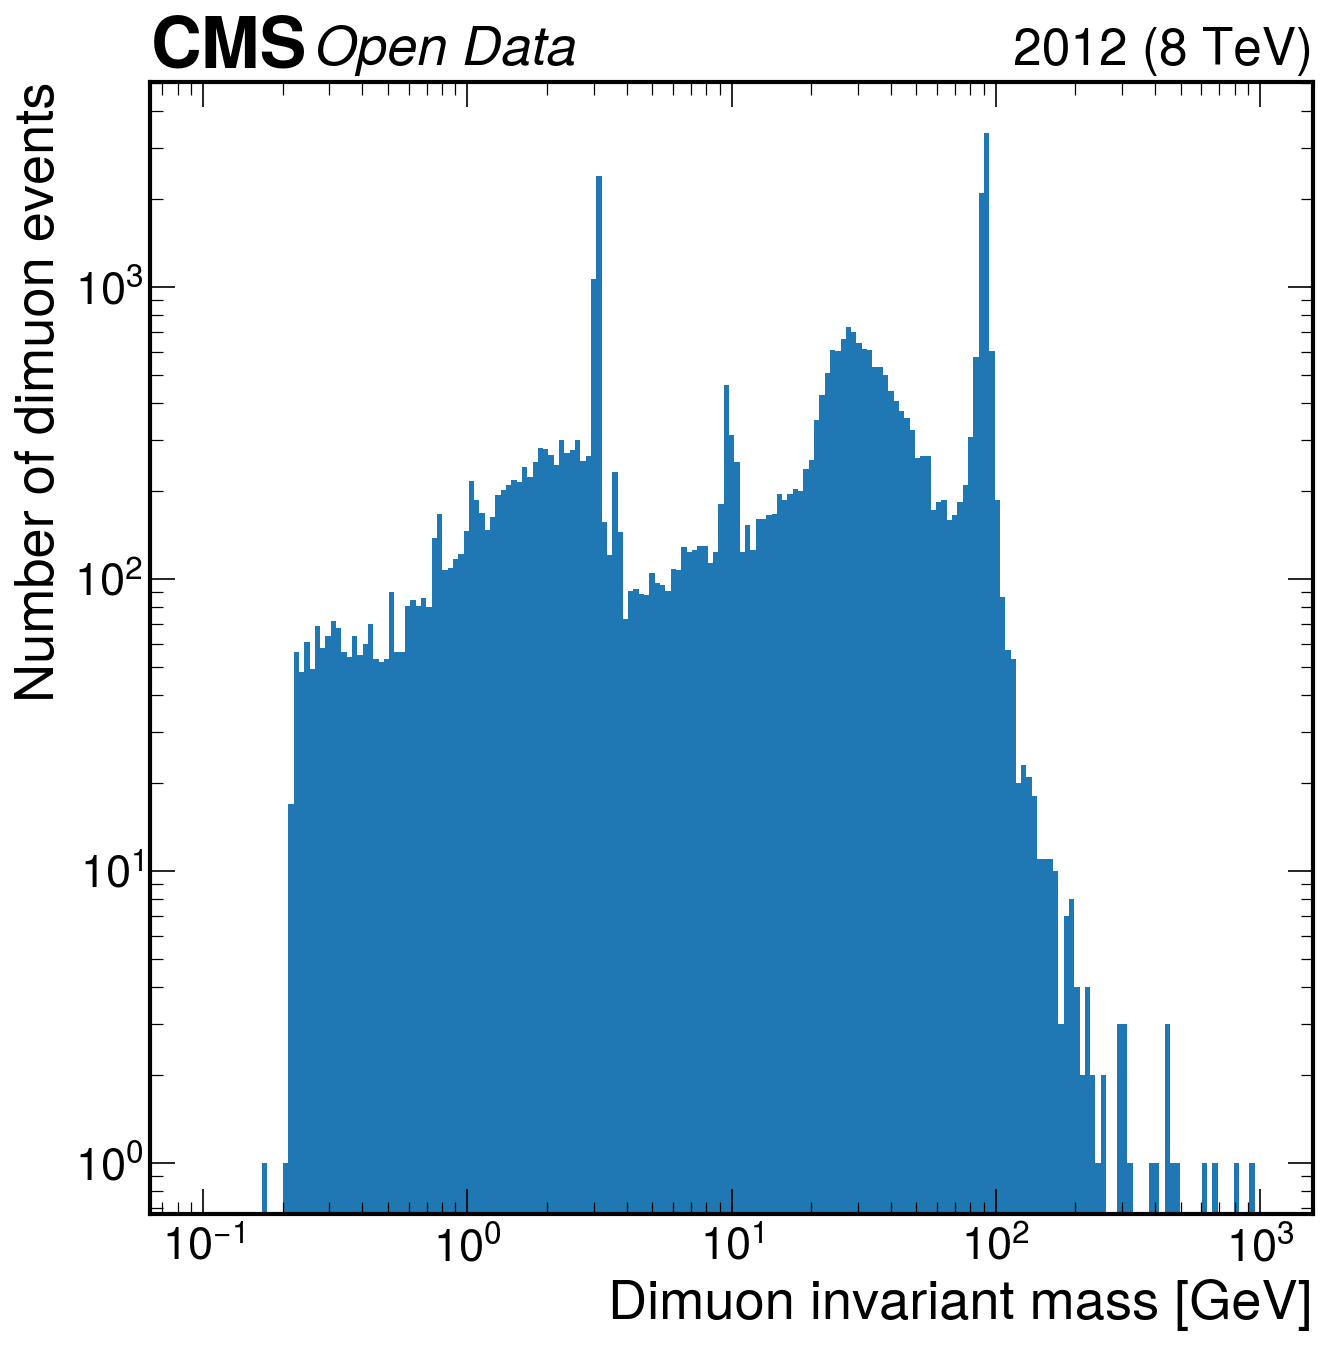

In [53]:
dimuon_mass_hist = hist.Hist(hist.axis.Variable(np.logspace(-1, 3, 200), label='Dimuon invariant mass [GeV]'))
dimuon_mass_hist.fill(dimuon_p4.mass)
hep.style.use('CMS')
hep.histplot(dimuon_mass_hist, histtype='fill')
hep.cms.label(data=True, label='Open Data', year=2012, com=8)
plt.xscale('log')
plt.ylabel('Number of dimuon events')
plt.yscale('log')

## Multiple files and large files

`uproot.open()` and `tree.arrays()` work fine for looking at one file at a time, but often trees are spread across several ROOT files. There are a few options to deal with this in Uproot.

The simplest is to join all the arrays:

`uproot.concatenate({'*.root': 'Events'})`

Another method is to iterate through the entries across all files:

```python
for events in uproot.iterate({'*.root': 'Events'}, step_size=100):
    # do something with events
```
In each iteration of the loop, `events` is a 100-row chunk of the full tree. This avoids loading all entries at the same time. This is important if the files are too large to fit into memory.

There are also some other techniques to reduce the memory usage. If you are only interested in looking at a few events, you can do:

In [54]:
tree.arrays(entry_stop=100)

<Array [{nMuon: 2, Muon_pt: [10.8, ... 1, -1]}] type='100 * {"nMuon": uint32, "M...'>

If you only need a subset of the branches from the tree, you can load each branch into an array individually, like:

In [55]:
tree['nMuon'].array()

<Array [2, 2, 1, 4, 4, 3, ... 0, 3, 2, 3, 2, 3] type='100000 * uint32'>

or you can provide a list of branch names to `arrays` to get only those branches:

In [56]:
tree.arrays(['Muon_pt', 'Muon_eta'])

<Array [{Muon_pt: [10.8, 15.7, ... 0.764]}] type='100000 * {"Muon_pt": var * flo...'>

My preference is to use `uproot.lazy()`:

In [57]:
lazy_branches = uproot.lazy({'open-data-example.root': 'Events'}, step_size=100000)

# New objects and files

So far, we've seen how Uproot, Awkward, and Vector can be used to read and manipulate data from already existing ROOT files. In this section, we'll look at how these packages can also be used to construct new objects and write data to files.

## Arrays

New `Arrays` can be easily be created like NumPy's `np.array`:

In [58]:
ak.Array([[1],
          [2, 3],
          [],
          [4]])

<Array [[1], [2, 3], [], [4]] type='4 * var * int64'>

## Vectors

Individual vectors can be created with `vector.obj`:

In [59]:
vector.obj(pt=1, eta=1, phi=1, e=2)

vector.obj(pt=1, phi=1, eta=1, E=2)

And we've already seen a way to make arrays of vectors:

In [60]:
vector.zip({'pt': ak.Array([1]),
            'eta': ak.Array([1]),
            'phi': ak.Array([1]),
            'e': ak.Array([2])})

<MomentumArray4D [{rho: 1, phi: 1, eta: 1, t: 2}] type='1 * Momentum4D["rho": in...'>

## Files

To write to a ROOT file, use `uproot.create()`, `uproot.recreate()`, or `uproot.update()`, which correspond to the same modes as in the `option` parameter of ROOT's `TFile.Open()`. For example, to create or replace `new_file.root`:

In [61]:
uproot.recreate('new_file.root')

<WritableDirectory '/' at 0x7f1d18beb3a0>

Writable file objects allow an assignment syntax for new elements, similar to a dictionary:
```
file['new_object_name'] = new_object
```

## Trees

Trees can be specified by an `Array` or a dictionary of arrays:

In [62]:
with uproot.update('new_file.root') as new_file:
    new_file['new_tree'] = {'branch1': ak.Array([1]), 'branch2': ak.Array([2])}

And just to make sure we can read this back:

In [63]:
uproot.open('new_file.root')['new_tree'].arrays()

<Array [{branch1: 1, branch2: 2}] type='1 * {"branch1": int64, "branch2": int64}'>

## Histograms

Histograms from Hist (or NumPy) can be interpreted into ROOT's `TH1`. Let's save our dimuon mass histogram to this new ROOT file:

In [64]:
with uproot.update('new_file.root') as new_file:
    new_file['new_histogram'] = dimuon_mass_hist

## Reopening

And again make sure we can read it back correctly:

In [65]:
t = uproot.open('new_file.root')['new_histogram']

/home/user/miniconda3/envs/agc-foundation-demo/lib/python3.10/site-packages/mplhep/utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


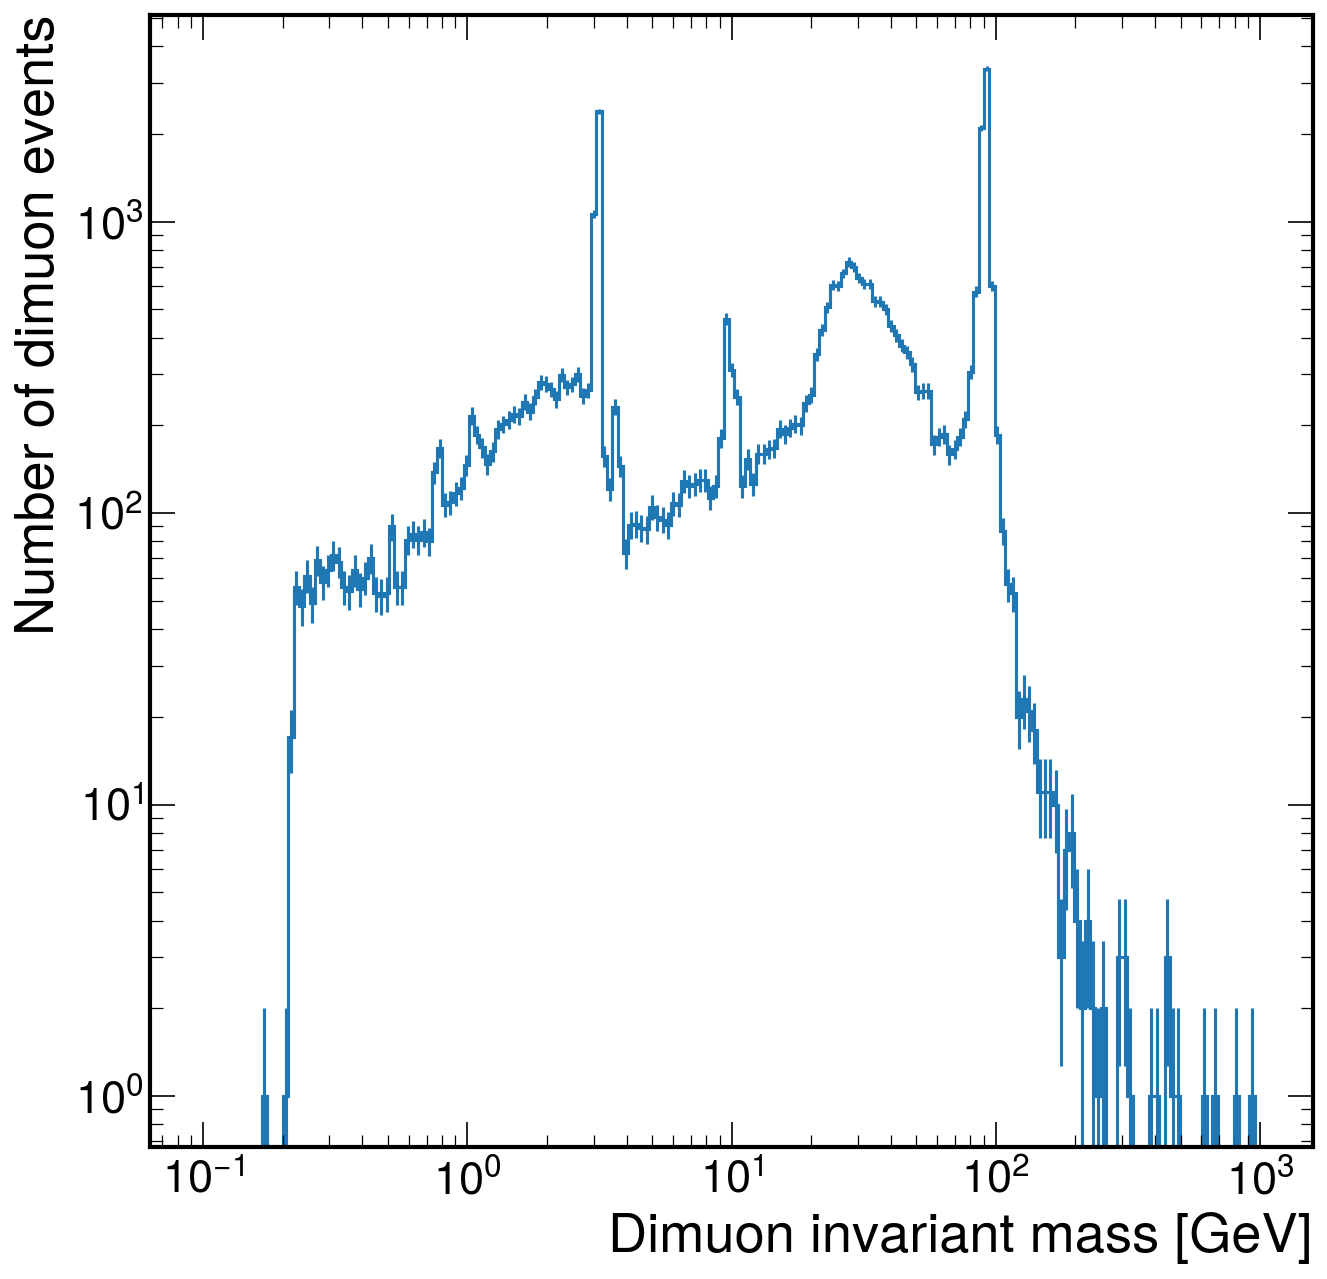

In [66]:
new_histogram = uproot.open('new_file.root')['new_histogram'].to_hist()
new_histogram.plot()
plt.ylabel('Number of dimuon events')
plt.xscale('log')
plt.yscale('log')
plt.show()

Of course ROOT can read these newly created files as well, which makes it easy to drop in an Uproot-based replacement for any part of an analysis, even if later steps still expect ROOT files as input.

# Aside: Numba support

Awkward Array also supports Numba, which is a library that just-in-time (JIT) compiles Python functions. This means that you can write loops in Python but use Numba to get close to C++ performance. This can be particularly helpful for analysis algorithms that are difficult to translate into fully columnar operations.

# Conclusion

There are many powerful Python packages available for HEP data analysis, and I've only breifly gone through a few of the most popular ones here. In summary, these packages (roughly) do the following:

- Uproot: read and write ROOT files
- Awkward Array: manipulate jagged arrays
- Vector: four-vector operations
- Hist: define and fill histograms
- mplhep: plot and style histograms

# Links to more detailed resources

- Uproot
    - [GitHub repository](https://github.com/scikit-hep/uproot4)
    - [Documentation](https://uproot.readthedocs.io/en/latest/)
- Awkward
    - [GitHub repository](https://github.com/scikit-hep/awkward-1.0)
        - Contains several links to other presentations/tutorials
    - [Documentation](https://awkward-array.org/quickstart.html)
- Vector
    - [GitHub repository](https://github.com/scikit-hep/vector)
    - [Documentation](https://vector.readthedocs.io/en/latest/)
- Hist
    - [GitHub repository](https://github.com/scikit-hep/hist)
    - [Documentation](https://hist.readthedocs.io/en/latest/)
- mplhep
    - [GitHub repository](https://github.com/scikit-hep/mplhep)
    - [Documentation](https://mplhep.readthedocs.io/en/latest/)